---
bibliography: ../references/references.bib
csl: ../references/abnt.csl
#tableEqns: true
---

# SINDy

Uma vez que os valores de uma grandeza qualquer sejam conhecidos para determinados instantes de tempo $t$, o método *Sparse Identification of Nonlinear Dynamic Systems (SINDy)* [@brunton2016] permite determinar, à partir dos dados os operadores $f$ que determinam a dinâmica do sistema, descrita por 

$$
\frac{d}{dt}x(t)=f(x(t)) \qquad (1)
$$

A principal hipótese por trás do método é que o sistema dinâmica é esparso no espaço de funções de base $f_i$ proposto, por exemplo, o sistema dinâmico descrito por

$$
\frac{d}{dt}x=f(t)=\begin{bmatrix} f_1(x) \\ f_2(x) \end{bmatrix} =
\begin{bmatrix} 1-x_1+3x_1x_2 \\ x_2^2-5x_1^3 \end{bmatrix}
$$

é esparso em um conjunto de funções de bases polinomiais de duas variáveis, uma vez que para funções de base $f_k=\sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$ um número pequeno de coeficientes $a_{i,j}$ serão diferentes de $0$. Se o operador $f(x)$ for representado por

$$
f(x)=\sum_{k=1}^p \theta_k(x)\xi_k
$$

, então  a dinâmica do sistema descrito pela equação (1) pode ser representado de maneira aproximada por 

$$
\dot{X} \approx \Theta(X)\Xi
$$

Onde $X$ é a matrix de $snapshots$

$$
X = \begin{bmatrix}
x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
\vdots & \vdots & & \vdots \\
x_1(t_n) & x_2(t_n) & \dots & x_n(t_n) 
\end{bmatrix}
$$

A matrix $\Theta(X)$ é uma matrix de funções de base aplicadas aos dados $X$

$$
\Theta(X) = \begin{bmatrix}
\vert & \vert & \vert & \vert \\
\theta_1(X) & \theta_2(X) & \dots & \theta_l(X)  \\
\vert & \vert & \vert & \vert
\end{bmatrix}
$$

As formas das funções de bases são determinadas pela escolha das `function libraries`. A busca é pelo conjunto de vetores de coeficientes esparsos $\xi_i$ com o maior número possível de coeficientes nulos.

$$
\Xi = \begin{bmatrix}
\vert & \vert & \vert& \vert\\
\xi_1 & \xi_2 & \dots & \xi_n\\
\vert & \vert& \vert& \vert\\
\end{bmatrix}
$$

Os coeficientes do vetor $\xi_k$ são determinados por algum dos algoritmos de regressão esparsa

$$
\xi_k = argmmin || \dot{X}_k-\Theta{(X)} \xi_k'||_2 + \lambda || \xi_k'||_1
$$

# Construindo um modelo pySINDy

Os principais dados de entrada para o método SINDy são

- Os snapshots $X$
  - São fornecidos com uma matrix 
- As derivadas $\dot{X}$, podem ser fornecidos no mesmo formato dos *snapshots* ou calculados com a função `psindy.differentiate`. As opções são.
  - `FiniteDifference`
  - `SINDyDerivative` wrapper para `dxdt` (`finite_difference, savitzky_golay, spectral, spline, trend_filtered, kalman`)
  - `SmoothedFiniteDifference`
  - `SpectralDerivative`
- As funções de base $\Theta$ , são especificadas no objeto `pysindy.feature_library`.
  - `CustomLibrary`
    ```python
    functions = [lambda x : np.exp(x), lambda x,y : np.sin(x+y)]
    lib = CustomLibrary(library_functions=functions)
    ```
  - `FourierLibrary` - Inclui funções $sin(x), sin(2x), ..., sin(nx)$, até frequências $n$.
  - `GeneralizedLibrary` - Agrupa várias bibliotecas.
    ```python
    functions = [lambda x : np.exp(x), lambda x,y : np.sin(x+y)]  
    lib_custom = CustomLibrary(library_functions=functions)
    lib_fourier = FourierLibrary()
    lib_generalized = GeneralizedLibrary([lib_custom, lib_fourier])
    ```
  - `IdentityLibrary` - Mapeia todas as variáveis de entrada na saída.
  - `PDELibrary` - Funções customizadas com derivadas de ordem arbitrária.
  - `PolynomialLibrary` - Funções polinomais.
  - `WeakPDELibrary` - As funções são integrais de derivadas das entrada multiplicadas por funções de teste.
  - `SINDyPILibrary` - Funções customizadas para os termos em $X$ e $\dot{X}$.
  - `TensoredLibrary` - Produto tensorial entre bibliotecas de funções.
- Otimizator, especificado no objeto `pysindy.optimizer`:
  - `STLSQ` - Sequentially Thresholded Least Squares algorithm:
    $$
    || \dot{X}-\Theta \Xi||_2^2 + \alpha||\Xi||_2^2
    $$
    Reference: [@brunton2016]

    Pseudocódigo:
    ```
    # Resolve o Sistema usando Mínimos Quadrados
    Xi = Theta/dxdt

    for k in (1...10)
      # Encontra Coeficientes Pequenos
      small_idx = (abs(Xi) < lambda)
      # Promove Esparsidade
      Xi(small_idx) = 0
      # Resolve o Sistema Regularizado Usando Mínimos Quadrados
      for idx = 1...n
        big_idx = !small_idx[:,idx]
        Xi[big_idx,:] = Theta[:,big_idx]/dXdt[:,idx]
    ```

  - `SR3` - Sparse Relaxed Regularized:
    $$
    0.5|| \dot{X}-\Theta \Xi||_2^2 + \lambda R(u) + (0.5/\nu)||\Xi-u||_2^2
    $$
    References: [@Zheng2019; @Champion2020]

  - `FROLS` - Forward Regression Orthogonal Least-Squares:
    $$
    || \dot{X}-\Theta \Xi||_2^2 + \alpha||\Xi||_2^2
    $$
    Reference: [@Billings2013]

  - `SINDy-PI`- SINDy-PI optimizer (base class `SR3`)

    $$
    0.5|| \dot{X}-\Theta \Xi||_2^2 + \lambda R(\Xi)
    $$

    Reference: [@Kaheman2020]

    - `SSR` - Stepwise Sparse Regression
    $$
    || \dot{X}-\Theta \Xi||_2^2 + \alpha ||\Xi||_2^2
    $$
    Reference: [@Boninsegna2018]

  - `TrappingSR3` - Trapping Sparse Relaxed Regularized:
    $$
    0.5||\dot{X}-\Theta \Xi||_2^2 + \lambda R(\Xi) + 0.5 ||P\Xi - A||_2^2/\eta + \delta_0(C\Xi-d)+\delta_{\Lambda}(A)
    $$
    ou
    $$
    0.5||\dot{X}-\Theta \Xi||_2^2 + \lambda R(\Xi) + \delta_0(C\Xi-d)+0.5 \cdot \text{maximumeingenvalue} (A)
    $$
    References: [@Kaptanoglu2021; @Zheng2019; @Champion2020]


Suponhamos um modelo dinâmico governado pelas EDOs

$$
\frac{d}{dt}\begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -2x \\ y \end{bmatrix}  
$$

, cuja solução analítica é $x(t)=x_0e^{-2t}$ e $y(t)=y_0e^{t}$. Vamos mostrar como o SINDy obtém as equações da dinâmica do sistema, a partir apenas de um conjunto de dados coletados no tempo.

In [1]:
import numpy as np
import pysindy as ps

# domínio temporal 
t = np.linspace(0,1,100)

# condições iniciais
x0 = 3
y0 = 0.5

# solução espaco-temporal
x = x0 * np.exp(-2 * t)
y = y0 * np.exp(t)

# snapshots
X = np.stack((x,y), axis=1)

In [2]:
# derivadas das snapshots
differentiation_method = ps.FiniteDifference(order=2)

In [3]:
# biblioteca de funções candidatas
feature_library = ps.PolynomialLibrary(degree=3)

In [4]:
# otimizador da função  custo
optimizer = ps.STLSQ(threshold=0.2)

In [5]:
# classe abstrada para o modelo SINDy
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

In [6]:
# aplica o otimizador para encontrar os coeficientes Xi
model.fit(X, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3), feature_names=['x', 'y'],
      optimizer=STLSQ(threshold=0.2))

In [7]:
# modelo identificado
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


In [8]:
# novas condições de contorno
x0 = 6
y0 = -0.1

# solução analalítica
t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

# integração do modelo indentificado pelo SINDy
sim = model.simulate([x0, y0], t=t_test)

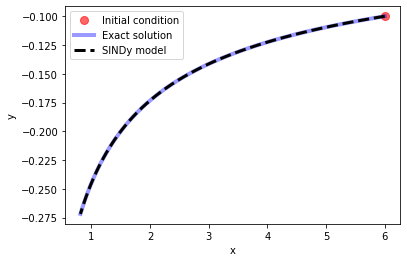

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [10]:
# funções seno 
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

# modelo identificado
model.fit(X, t=t)
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)


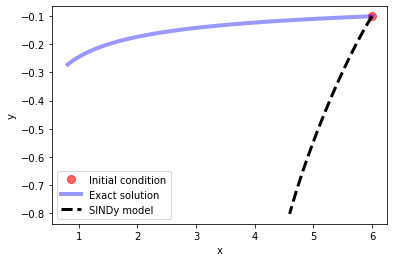

In [11]:
sim = model.simulate([x0, y0], t=t_test)

plt.figure()
plt.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
plt.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()